# ECON320 Week 10 — Heteroskedasticity (Completed version)


**Learning goals**

- When are these *t/F* p-values dependable?

  - *Classical:* dependable in small samples if **MLR.6 (normal errors)**, **constant spread** (homoskedasticity), **independent** observations, and a **correct linear mean** hold.

  - *Robust (HC0):* dependable in **large samples** even without normality or constant spread; still needs **independence** and **exogeneity**. Small-sample p-values are **approximate**.

- Spot & diagnose heteroskedasticity. 

    - Residuals‑vs‑fitted **funnel/uneven** pattern as a clue.
    
    - Use **Breusch–Pagan (BP)** and **White** p‑values as formal checks.

- Conduct OLS analysis with heteroskedasticity-robust standard errors.

    - Fit OLS and report **HC0** SEs.

---

## 📦 Required libraries

In [1]:

!pip install -q numpy pandas statsmodels scipy matplotlib 

import numpy as np, pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


---

## Part A. Intuition

### 🔄 A1) Quick recall: *t*-tests under MLR.6 and **constant spread**

- **MLR.6 (Normal errors):** 
$$
u_i\mid X \sim \mathcal N(0,\sigma^2)
$$.
- **Constant spread (homoskedasticity):** 
$$
\mathrm{Var}(u_i\mid X)=\sigma^2
$$.

- With these, the standard *t/F* reported by software are **trustworthy even in small samples**.

- **Decision (two‑sided @ level $\alpha$).** Reject $H_0:\beta_j=0$ if the two‑sided p‑value $<\alpha$.

<hr style="border: 1px dotted #bbb;">


### 🧠 A2) Bridge: What if the spread isn’t constant (fan/funnel shape)?

- Real data often show a **funnel**: residual spread grows/shrinks with $x$.

- One pooled noise number can then **over‑ or under‑reject**.

- **Fix:** same regression and test recipe, but request **White/Huber/Eicker (HC0)** **robust** SEs with `.fit(cov_type="HC0")`.  

    Software computes them; you read the table (default robust p‑values use a normal “z” reference).

<hr style="border: 1px dotted #bbb;">



### 👀 A3) Tiny visual: what does it mean by funnel shape (income story)
**Story / intuition.** Think in *percent vs dollars*:
- If errors are about **10%** everywhere, then at **$20** income a 10% miss is **$2**, but at **$200** it’s **$20**.  
- Same **percentage** error ⇒ **bigger absolute** miss when income is larger.  
- On the plot, that shows up as a **funnel**: points spread out as $x$ increases (a possible story — not the only cause).


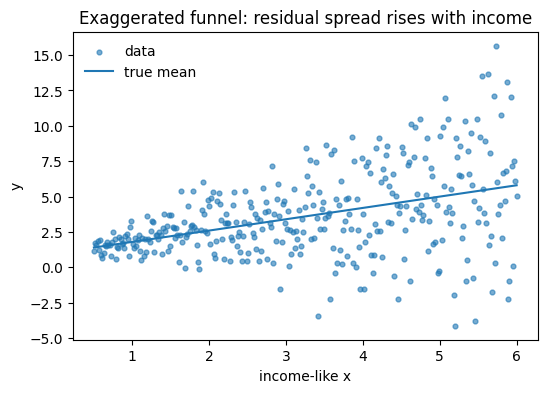

In [2]:

# Exaggerated funnel: y vs "income"-like x with variance that grows sharply
n_plot = 350
x_plot = np.linspace(0.5, 6.0, n_plot)
sigma_plot = 0.10 + 0.70 * x_plot          # exaggerated spread
y_true = 1.0 + 0.8 * x_plot
y_plot = y_true + np.random.normal(scale=sigma_plot, size=n_plot)

plt.figure(figsize=(6,4))
plt.scatter(x_plot, y_plot, s=12, alpha=0.6, label="data")
plt.plot(x_plot, y_true, label="true mean")
plt.title("Exaggerated funnel: residual spread rises with income")
plt.xlabel("income-like x"); plt.ylabel("y")
plt.legend(frameon=False); plt.show()

---

## Part B. Experiment

### B1) Quick demo: OLS when variance grows with $|x_1|$
We simulate
$$
y_i = 1 + 0\,x_{1i} + 0.8\,x_{2i} - 0.5\,x_{3i} + u_i,\qquad
u_i \sim \mathcal N(0,\,\sigma_i^2),\ \ \sigma_i = 0.5 + 1.0\,|x_{1i}|.
$$


In [3]:

# --- DGP: income-style funnel (variance rises with x1) ---
seed = 40
rng = np.random.default_rng(seed)
n = 180

# x1 positive → clearer funnel in residuals vs x1
x1 = rng.normal(size=n)
x2 = rng.normal(size=n)
x3 = rng.normal(size=n)

# Heteroskedasticity: variance increases with x1 (megaphone/funnel)
sigma_i = 0.5 + 1 * np.abs(x1)
u = rng.normal(scale=sigma_i, size=n)

beta1 = 0.0  # H0 true to illustrate over-rejection (classical)
y = 1.0 + beta1*x1 + 0.8*x2 - 0.5*x3 + u

X = sm.add_constant(pd.DataFrame({"x1": x1, "x2": x2, "x3": x3}))

model       = sm.OLS(y, X)
ols_classic = model.fit()                 # classical (assumes constant spread)
ols_hc0     = model.fit(cov_type="HC0")   # robust (White/Huber/Eicker), z-based p-values

# Compact coefficient tables for quick lecture read
print("=== Classical (assumes constant spread) ===")
print(ols_classic.summary().tables[1])

print("\n=== Robust (HC0, z-based) ===")
print(ols_hc0.summary().tables[1])


=== Classical (assumes constant spread) ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9107      0.118      7.702      0.000       0.677       1.144
x1             0.2684      0.119      2.254      0.025       0.033       0.503
x2             0.7932      0.108      7.360      0.000       0.580       1.006
x3            -0.5469      0.117     -4.664      0.000      -0.778      -0.315

=== Robust (HC0, z-based) ===
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9107      0.119      7.628      0.000       0.677       1.145
x1             0.2684      0.172      1.560      0.119      -0.069       0.606
x2             0.7932      0.115      6.873      0.000       0.567       1.019
x3            -0.5469      0.101     -5.416      0.000  


<hr style="border: 1px dotted #bbb;">

### B2) Diagnostic: residuals vs $x_1$

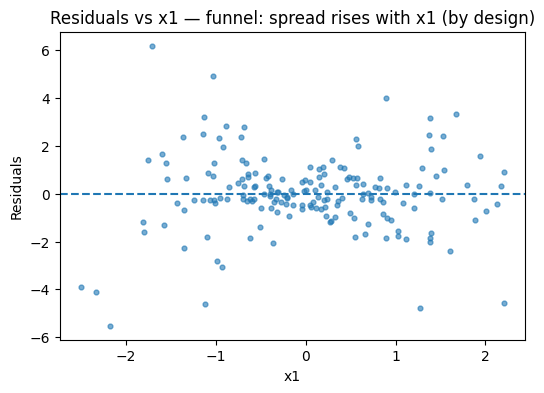

In [4]:

# Clear funnel diagnostic: residuals vs x1
plt.figure(figsize=(6,4))
plt.scatter(x1, ols_classic.resid, s=12, alpha=0.6)
plt.axhline(0, ls="--")
plt.title("Residuals vs x1 — funnel: spread rises with x1 (by design)")
plt.xlabel("x1"); plt.ylabel("Residuals")
plt.show()



<hr style="border: 1px dotted #bbb;">

### B3) BP & White tests — what they do
- **Goal:** check **homoskedasticity** (constant spread).  

- **Breusch–Pagan (BP):** asks whether the **squared residuals** grow **linearly** with the original regressors.
  
  - Auxiliary regression:
    $$
    e_i^2 \;=\; a_0 \;+\; a_1 x_{1i} \;+\; \cdots \;+\; a_k x_{ki} \;+\; \text{noise}.
    $$
  - LM statistic and reference:
    $$
    \mathrm{LM} \;=\; n\,R^2_{\text{aux}} \;\sim\; \chi^2_{m}\quad\text{under }H_0,
    $$
    where $m$ is the **number of slope terms** in the auxiliary regression (**do not** count the intercept).  
    *If you include all $k$ original regressors, then $m=k$.*

- **White test:** allows **nonlinear** variance by adding **squares** and **cross-products** of the regressors.
  
  - Let $\mathcal W$ be the set containing $x_{1i},\dots,x_{ki}$, their squares $x_{1i}^2,\dots,x_{ki}^2$, and all pairwise products $x_{ri}x_{si}$ ($r<s$).
  - Auxiliary regression:
    $$
    e_i^2 \;=\; b_0 \;+\; \sum_{w\in\mathcal W} b_w\,w_i \;+\; \text{noise}.
    $$
  - LM statistic and reference:
    $$
    \mathrm{LM} \;=\; n\,R^2_{\text{aux}} \;\sim\; \chi^2_{d}\quad\text{under }H_0,
    $$
    where $d$ is the **number of slope terms** used from $\mathcal W$ (**do not** count the intercept).

- **Decision rule (both tests):** pick a level $\alpha$ (e.g., 0.05). 
    - If the **p-value** from the test is **below $\alpha$**, **reject** homoskedasticity; otherwise, **do not reject**.


In [5]:
from statsmodels.stats import diagnostic as sm_diagnostic

bp_lm, bp_lm_p, _, _       = sm_diagnostic.het_breuschpagan(ols_classic.resid, X)
white_lm, white_lm_p, _, _ = sm_diagnostic.het_white(ols_classic.resid, X)

print({"BP_p": float(bp_lm_p), "White_p": float(white_lm_p)})

alpha = 0.05
print(f"Decision @ {alpha*100:.0f}%: "+ (
      "Reject homoskedasticity (variance not constant)"
      if (bp_lm_p < alpha or white_lm_p < alpha)
      else "No strong evidence against homoskedasticity"))


{'BP_p': 0.0517526213407861, 'White_p': 1.3035076700422066e-06}
Decision @ 5%: Reject homoskedasticity (variance not constant)


---


## Takeaways
- If residual spread looks **uneven** (funnel), prefer **robust** SEs (White/Huber/Eicker, HC0) for inference. 

- Same workflow: fit OLS once, request **HC0** via `.fit(cov_type="HC0")`, and read the table. 
 
- Use the plot + **BP/White** p‑values together for diagnosing heteroskedasticity.


> **Assumption note — what HC0 fixes (and what it doesn’t):**
>
> - HC0 fixes **non‑constant variance** (heteroskedasticity). 
>
> - You still need **exogeneity** ($E[u_i \mid X_i]=0$), **independent** observations (no serial/cluster correlation — use **clustered/HAC** SEs if present), and **no perfect multicollinearity**.



---
## References & Acknowledgments

- This teaching material was prepared with the assistance of **OpenAI's ChatGPT (GPT-5)**.

---

**End of lecture notebook.**